In [2]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from nba_api.stats.endpoints import playercareerstats, commonplayerinfo
from nba_api.stats.static import players
import pandas as pd
import numpy as np
import pickle
import os

In [3]:
# Create a custom requests session
session = requests.Session()
retries = Retry(total=15, backoff_factor=1, status_forcelist=[ 429, 500, 502, 503, 504 ])
session.mount('https://', HTTPAdapter(max_retries=retries))

In [4]:
# Directory for caching
cache_dir = 'player_stats_cache'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

# Cache functions
def cache_exists(player_id, season, data_type):
    return os.path.exists(os.path.join(cache_dir, f'{player_id}_{season}_{data_type}.pkl'))

def load_from_cache(player_id, season, player_name, data_type):
    file_path = os.path.join(cache_dir, f'{player_id}_{season}_{data_type}.pkl')
    try:
        with open(file_path, 'rb') as file:
            return pickle.load(file)
    except (EOFError, FileNotFoundError):
        print(f"Cache file for player {player_id} {player_name}, season {season}, type {data_type} is corrupted or missing.")
        if os.path.exists(file_path):
            os.remove(file_path)
        return None

def save_to_cache(player_id, season, data_type, data):
    file_path = os.path.join(cache_dir, f'{player_id}_{season}_{data_type}.pkl')
    with open(file_path, 'wb') as file:
        pickle.dump(data, file)


In [5]:
CURRENT_SEASON = '2023-24'

In [6]:
from datetime import datetime
from nba_api.stats.endpoints import playergamelog

def fetch_player_game_data(player_id, season, player_name):
    cached_games = load_from_cache(player_id, season, player_name, "games")
    today = datetime.today()

    # Convert 'GAME_DATE' in cached data to datetime
    if cached_games is not None and not cached_games.empty:
        cached_games['GAME_DATE'] = pd.to_datetime(cached_games['GAME_DATE'], format='%b %d, %Y')

    # Check if cached data is outdated or missing
    if cached_games is None or (season == CURRENT_SEASON and (cached_games.empty or cached_games['GAME_DATE'].max() < today)):
        # Fetch new game data from API
        game_log = playergamelog.PlayerGameLog(player_id=player_id, season=season)
        new_game_data = game_log.get_data_frames()[0]
        new_game_data['GAME_DATE'] = pd.to_datetime(new_game_data['GAME_DATE'], format='%b %d, %Y')

        # Append new data to cached data if necessary
        if cached_games is not None and not cached_games.empty and season == CURRENT_SEASON:
            combined_data = pd.concat([cached_games, new_game_data]).drop_duplicates().sort_values(by=['GAME_DATE'], ascending=False).reset_index(drop=True)
            save_to_cache(player_id, season, "games", combined_data)
            return combined_data
        else:
            save_to_cache(player_id, season, "games", new_game_data)
            return new_game_data
    else:
        return cached_games


In [7]:
weights = {
    "FGM": 35,
    "FGA": -10,
    "FG3M": 2.5,
    "FTM": 8,
    "FTA": -3,
    "OREB": 5,
    "REB": 8,
    "AST": 17,
    "STL": 30,
    "BLK": 30,
    "TOV": -15,
    "PTS": 5,
}

default_weights = {
    "FGM": 2,
    "FGA": -1,
    "FG3M": 1,
    "FTM": 1,
    "FTA": -1,
    "OREB": 0,
    "REB": 1,
    "AST": 2,
    "STL": 4,
    "BLK": 4,
    "TOV": -2,
    "PTS": 1,
}

# weights = default_weights

In [128]:
# check if it needs to be removed

for player in current_players:
    player_id = player['id']
    player_name = player['full_name']

    try:
        # Fetch player career stats
        career = playercareerstats.PlayerCareerStats(player_id=player_id, timeout=60)
        career_df = career.get_data_frames()[0]
        # print(career_df)

        for index, row in career_df.iterrows():
            season = row['SEASON_ID']
            cached_data = load_from_cache(player_id, season, player_name) if season != CURRENT_SEASON else None

            if cached_data is None:
                # Fetch detailed player info for position
                player_info = commonplayerinfo.CommonPlayerInfo(player_id=player_id, timeout=60).get_data_frames()[0]
                position = player_info['POSITION'][0]

                # Add player info to the row
                row['PLAYER_NAME'] = player['full_name']
                row['POSITION'] = position

                # Prepare DataFrame for this row
                relevant_stats = pd.DataFrame([row[['PLAYER_ID', 'SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'PLAYER_AGE', 'GP', 'MIN',
                                                    'FGM', 'FGA', 'FTM', 'FTA', 'FG3M', 'PTS', 'OREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 
                                                    'PLAYER_NAME', 'POSITION']]])

                # Save the data to cache
                save_to_cache(player_id, season, relevant_stats.iloc[0])
                player_stats_list.append(relevant_stats)
            else:
                # Use cached data
                player_stats_list.append(pd.DataFrame([cached_data]))

    except requests.exceptions.RequestException as e:
        print(f"Request failed for player {player_id} {player_name}: {e}")
        continue

In [8]:
#main code
data_type = 'season'

# Fetch current NBA players
current_players = players.get_active_players()

# List to store player stats DataFrames
player_stats_list = []
all_players_game_data = []

for player in current_players:
    player_id = player['id']
    player_name = player['full_name']

    try:
        # Fetch player career stats
        career_stats = playercareerstats.PlayerCareerStats(player_id=player_id, timeout=60)
        career_stats_df = career_stats.get_data_frames()[0]

        for season in career_stats_df['SEASON_ID'].unique():
            season_data = career_stats_df[career_stats_df['SEASON_ID'] == season].copy()
            cached_data = load_from_cache(player_id, season, player_name, data_type) if season != CURRENT_SEASON else None

            if cached_data is None or not isinstance(cached_data, pd.DataFrame) or 'TEAM_ABBREVIATION' not in cached_data.columns:
                # Fetch detailed player info for position
                player_info = commonplayerinfo.CommonPlayerInfo(player_id=player_id, timeout=60).get_data_frames()[0]
                position = player_info['POSITION'][0]

                # Add player info to the season data using .loc
                season_data.loc[:, 'PLAYER_NAME'] = player_name
                season_data.loc[:, 'POSITION'] = position

                # Save the season data to cache
                save_to_cache(player_id, season, data_type, season_data)
                player_stats_list.append(season_data)
            else:
                # Check if cached data is a DataFrame and append
                if isinstance(cached_data, pd.DataFrame):
                    player_stats_list.append(cached_data)
                else:
                    print(f"Cached data format error for player {player_id} {player_name}, season {season}")

            # Fetch individual game data for the player and season
            game_data = fetch_player_game_data(player_id, season, player_name)

            # Add player name and season to the game data for reference
            game_data.loc[:, 'PLAYER_NAME'] = player_name
            game_data.loc[:, 'SEASON_ID'] = season

            # Append the game data to the list
            all_players_game_data.append(game_data)

    except requests.exceptions.RequestException as e:
        print(f"Request failed for player {player_id} {player_name}: {e}")
        continue


Cache file for player 202711 Bojan Bogdanovic, season 2023-24, type games is corrupted or missing.
Request failed for player 1631107 Nikola Jovic: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Request failed for player 203490 Otto Porter Jr.: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Cache file for player 1629020 Jarred Vanderbilt, season 2023-24, type games is corrupted or missing.


In [9]:
# Concatenate all DataFrames in the list
player_stats_df = pd.concat(player_stats_list, ignore_index=True)

# Displaying the first few rows of the DataFrame
player_stats_df.to_pickle('player_stats.pkl')
player_stats_df

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLAYER_NAME,POSITION
0,1630173,2020-21,00,1610612748,MIA,21.0,61,4,737.0,124,...,135,208,29,20,28,43,91,304,Precious Achiuwa,Forward
1,1630173,2021-22,00,1610612761,TOR,22.0,73,28,1725.0,265,...,327,473,82,37,41,84,151,664,Precious Achiuwa,Forward
2,1630173,2022-23,00,1610612761,TOR,23.0,55,12,1141.0,196,...,228,328,50,31,30,59,102,508,Precious Achiuwa,Forward
3,1630173,2023-24,00,1610612761,TOR,24.0,14,0,254.0,41,...,54,86,28,8,6,18,25,102,Precious Achiuwa,Forward
4,203500,2013-14,00,1610612760,OKC,20.0,81,20,1197.0,93,...,190,332,43,40,57,71,203,265,Steven Adams,Center
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3294,1627826,2019-20,00,1610612746,LAC,23.0,72,70,1326.0,236,...,346,543,82,16,66,61,168,596,Ivica Zubac,Center
3295,1627826,2020-21,00,1610612746,LAC,24.0,72,33,1609.0,257,...,330,519,90,24,62,81,187,650,Ivica Zubac,Center
3296,1627826,2021-22,00,1610612746,LAC,25.0,76,76,1852.0,310,...,427,644,120,36,77,114,203,785,Ivica Zubac,Center
3297,1627826,2022-23,00,1610612746,LAC,26.0,76,76,2169.0,326,...,520,756,77,29,98,117,219,818,Ivica Zubac,Center


In [10]:
# Concatenate all individual game data into a single DataFrame
all_games_df = pd.concat(all_players_game_data, ignore_index=True)
all_games_df.to_pickle('all_games.pkl')
all_games_df

,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,PLAYER_NAME
0,2020-21,1630173,0022001069,2021-05-16,MIA @ DET,W,42,10,16,0.625,...,10,0,2,1,2,3,23,6,1,Precious Achiuwa
1,2020-21,1630173,0022001062,2021-05-15,MIA @ MIL,L,2,1,2,0.500,...,0,1,0,0,0,0,2,3,1,Precious Achiuwa
2,2020-21,1630173,0022001050,2021-05-13,MIA vs. PHI,W,2,0,0,0.000,...,0,0,0,0,0,0,0,-5,1,Precious Achiuwa
3,2020-21,1630173,0022000986,2021-05-04,MIA vs. DAL,L,6,1,2,0.500,...,1,1,0,1,0,0,2,12,1,Precious Achiuwa
4,2020-21,1630173,0022000969,2021-05-02,MIA @ CHA,W,1,0,1,0.000,...,0,0,0,0,0,0,0,-3,1,Precious Achiuwa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142792,2023-24,1627826,0022300127,2023-11-01,LAC @ LAL,L,29,3,8,0.375,...,9,0,0,0,1,5,7,-6,1,Ivica Zubac
142793,2023-24,1627826,0022300114,2023-10-31,LAC vs. ORL,W,23,4,8,0.500,...,9,1,0,1,1,1,9,19,1,Ivica Zubac
142794,2023-24,1627826,0022300099,2023-10-29,LAC vs. SAS,W,22,6,7,0.857,...,8,0,0,1,1,4,16,23,1,Ivica Zubac
142795,2023-24,1627826,0022300085,2023-10-27,LAC @ UTA,L,19,3,6,0.500,...,2,0,0,2,1,2,6,1,1,Ivica Zubac


In [10]:
player_stats_df.to_csv('player_stats.csv', index=False)

In [8]:
player_stats_df = pd.read_pickle('player_stats.pkl')
all_games_df = pd.read_pickle('all_games.pkl')
# df_lebron = pd.read_pickle('player_stats_cache/2544_2023-24_games.pkl')
# df_lebron

In [9]:
from decimal import Decimal, ROUND_HALF_UP

def custom_round(value, decimals):
    return float(Decimal(value).quantize(Decimal('0.' + '0' * decimals), rounding=ROUND_HALF_UP))

# List of stat columns to convert to per game stats
stat_columns = ['MIN', 'FGM', 'FGA', 'FTM', 'FTA', 'FG3M', 'PTS', 'OREB', 'REB', 'AST', 'STL', 'BLK', 'TOV']

# Create a new DataFrame for per game stats
per_game_stats_df = player_stats_df.copy()

# Rename original stat columns temporarily
temp_column_names = {col: f'{col}_total' for col in stat_columns}
per_game_stats_df.rename(columns=temp_column_names, inplace=True)

for column in stat_columns:
    per_game_stats_df[column] = per_game_stats_df[f'{column}_total'] / per_game_stats_df['GP']
    per_game_stats_df[column] = per_game_stats_df[column].apply(lambda x: custom_round(x, 1))

# Drop the original (now renamed) cumulative stat columns
per_game_stats_df.drop(list(temp_column_names.values()), axis=1, inplace=True)

# Display the new DataFrame
per_game_stats_df


,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,FG_PCT,FG3A,...,FTM,FTA,FG3M,PTS,OREB,REB,AST,STL,BLK,TOV
0,1630173,2020-21,00,1610612748,MIA,21.0,61,4,0.544,1,...,0.9,1.8,0.0,5.0,1.2,3.4,0.5,0.3,0.5,0.7
1,1630173,2021-22,00,1610612761,TOR,22.0,73,28,0.439,156,...,1.1,1.8,0.8,9.1,2.0,6.5,1.1,0.5,0.6,1.2
2,1630173,2022-23,00,1610612761,TOR,23.0,55,12,0.485,108,...,1.6,2.3,0.5,9.2,1.8,6.0,0.9,0.6,0.5,1.1
3,1630173,2023-24,00,1610612761,TOR,24.0,14,0,0.432,23,...,1.0,1.8,0.4,7.3,2.3,6.1,2.0,0.6,0.4,1.3
4,203500,2013-14,00,1610612760,OKC,20.0,81,20,0.503,0,...,1.0,1.7,0.0,3.3,1.8,4.1,0.5,0.5,0.7,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3294,1627826,2019-20,00,1610612746,LAC,23.0,72,70,0.613,2,...,1.7,2.3,0.0,8.3,2.7,7.5,1.1,0.2,0.9,0.8
3295,1627826,2020-21,00,1610612746,LAC,24.0,72,33,0.652,4,...,1.9,2.4,0.0,9.0,2.6,7.2,1.3,0.3,0.9,1.1
3296,1627826,2021-22,00,1610612746,LAC,25.0,76,76,0.626,0,...,2.2,3.0,0.0,10.3,2.9,8.5,1.6,0.5,1.0,1.5
3297,1627826,2022-23,00,1610612746,LAC,26.0,76,76,0.634,2,...,2.2,3.1,0.0,10.8,3.1,9.9,1.0,0.4,1.3,1.5


In [23]:
# Add weighted stat columns
for stat, weight in weights.items():
    per_game_stats_df[f'{stat}_PTS'] = (per_game_stats_df[stat] * weight).round(2)

      PLAYER_ID SEASON_ID LEAGUE_ID     TEAM_ID TEAM_ABBREVIATION  PLAYER_AGE  \
0       1630173   2020-21        00  1610612748               MIA        21.0   
1       1630173   2021-22        00  1610612761               TOR        22.0   
2       1630173   2022-23        00  1610612761               TOR        23.0   
3       1630173   2023-24        00  1610612761               TOR        24.0   
4        203500   2013-14        00  1610612760               OKC        20.0   
...         ...       ...       ...         ...               ...         ...   
3294    1627826   2019-20        00  1610612746               LAC        23.0   
3295    1627826   2020-21        00  1610612746               LAC        24.0   
3296    1627826   2021-22        00  1610612746               LAC        25.0   
3297    1627826   2022-23        00  1610612746               LAC        26.0   
3298    1627826   2023-24        00  1610612746               LAC        26.0   

      GP  GS  FG_PCT  FG3A 

In [11]:
# List of all weighted stat columns
weighted_stat_columns = [f'{stat}_PTS' for stat in weights.keys()]

# Calculate total points
per_game_stats_df['TOTAL'] = per_game_stats_df[weighted_stat_columns].sum(axis=1).round(2)

# Display the first few rows of the updated DataFrame
per_game_stats_df

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,FG_PCT,FG3A,...,FTM_PTS,FTA_PTS,OREB_PTS,REB_PTS,AST_PTS,STL_PTS,BLK_PTS,TOV_PTS,PTS_PTS,TOTAL
0,1630173,2020-21,00,1610612748,MIA,21.0,61,4,0.544,1,...,7.2,-5.4,6.0,27.2,8.5,9.0,15.0,-10.5,25.0,115.00
1,1630173,2021-22,00,1610612761,TOR,22.0,73,28,0.439,156,...,8.8,-5.4,10.0,52.0,18.7,15.0,18.0,-18.0,45.5,189.60
2,1630173,2022-23,00,1610612761,TOR,23.0,55,12,0.485,108,...,12.8,-6.9,9.0,48.0,15.3,18.0,15.0,-16.5,46.0,194.95
3,1630173,2023-24,00,1610612761,TOR,24.0,14,0,0.432,23,...,8.0,-5.4,11.5,48.8,34.0,18.0,12.0,-19.5,36.5,178.40
4,203500,2013-14,00,1610612760,OKC,20.0,81,20,0.503,0,...,8.0,-5.1,9.0,32.8,8.5,15.0,21.0,-13.5,16.5,107.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3294,1627826,2019-20,00,1610612746,LAC,23.0,72,70,0.613,2,...,13.6,-6.9,13.5,60.0,18.7,6.0,27.0,-12.0,41.5,223.90
3295,1627826,2020-21,00,1610612746,LAC,24.0,72,33,0.652,4,...,15.2,-7.2,13.0,57.6,22.1,9.0,27.0,-16.5,45.0,236.20
3296,1627826,2021-22,00,1610612746,LAC,25.0,76,76,0.626,0,...,17.6,-9.0,14.5,68.0,27.2,15.0,30.0,-22.5,51.5,270.80
3297,1627826,2022-23,00,1610612746,LAC,26.0,76,76,0.634,2,...,17.6,-9.3,15.5,79.2,17.0,12.0,39.0,-22.5,54.0,285.00


In [ ]:
#1. To get just the stats, team info is listed as TOT for traded players. 

# Identify traded players (those who have a 'TOT' row in any season)
traded_players = per_game_stats_df[per_game_stats_df['TEAM_ABBREVIATION'] == 'TOT']['PLAYER_ID'].unique()

# DataFrame to store the final filtered data
final_df = pd.DataFrame()

for player_id in traded_players:
    # Filter to get all rows for this player
    player_df = per_game_stats_df[per_game_stats_df['PLAYER_ID'] == player_id]

    # Iterate through each unique season for the player
    for season in player_df['SEASON_ID'].unique():
        player_season_df = player_df[player_df['SEASON_ID'] == season]

        # Check if 'TOT' is present for this season
        if 'TOT' in player_season_df['TEAM_ABBREVIATION'].values:
            # Get the 'TOT' row
            tot_row = player_season_df[player_season_df['TEAM_ABBREVIATION'] == 'TOT']

            # Get the row for the latest team in that season (last row before 'TOT')
            latest_team_row = player_season_df[player_season_df['TEAM_ABBREVIATION'] != 'TOT'].iloc[-1:]

            # Append both rows to final_df
            final_df = pd.concat([final_df, tot_row, latest_team_row])
        else:
            # If 'TOT' is not present, append the whole season data
            final_df = pd.concat([final_df, player_season_df])

# Add data for players who were not traded
non_traded_players_df = per_game_stats_df[~per_game_stats_df['PLAYER_ID'].isin(traded_players)]
final_df = pd.concat([final_df, non_traded_players_df]).drop_duplicates(subset=['PLAYER_ID', 'SEASON_ID'])

# Display the DataFrame to verify
final_df


In [12]:
#2. number 1 + the latest team the player was in on the traded season

# DataFrame to store the final filtered data
final_df = pd.DataFrame()

# Process data for each player
for player_id in per_game_stats_df['PLAYER_ID'].unique():
    # Filter to get all rows for this player
    player_df = per_game_stats_df[per_game_stats_df['PLAYER_ID'] == player_id]

    # Iterate through each unique season for the player
    for season in player_df['SEASON_ID'].unique():
        player_season_df = player_df[player_df['SEASON_ID'] == season]

        # Check if 'TOT' is present for this season
        if 'TOT' in player_season_df['TEAM_ABBREVIATION'].values:
            # Get the 'TOT' row
            tot_row = player_season_df[player_season_df['TEAM_ABBREVIATION'] == 'TOT']

            # Get the row for the latest team in that season (last row before 'TOT')
            latest_team_row = player_season_df[(player_season_df['TEAM_ABBREVIATION'] != 'TOT') & 
                                               (player_season_df['TEAM_ID'] != 0)].iloc[-1:]

            # Append both 'TOT' row and latest team row to final_df
            final_df = pd.concat([final_df, tot_row, latest_team_row])
        else:
            # If 'TOT' is not present, append the whole season data
            final_df = pd.concat([final_df, player_season_df])

# Removing potential duplicates (if any)
final_df = final_df.drop_duplicates(subset=['PLAYER_ID', 'SEASON_ID', 'TEAM_ID'])

# Display the DataFrame to verify
final_df


,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,FG_PCT,FG3A,...,FTM_PTS,FTA_PTS,OREB_PTS,REB_PTS,AST_PTS,STL_PTS,BLK_PTS,TOV_PTS,PTS_PTS,TOTAL
0,1630173,2020-21,00,1610612748,MIA,21.0,61,4,0.544,1,...,7.2,-5.4,6.0,27.2,8.5,9.0,15.0,-10.5,25.0,115.00
1,1630173,2021-22,00,1610612761,TOR,22.0,73,28,0.439,156,...,8.8,-5.4,10.0,52.0,18.7,15.0,18.0,-18.0,45.5,189.60
2,1630173,2022-23,00,1610612761,TOR,23.0,55,12,0.485,108,...,12.8,-6.9,9.0,48.0,15.3,18.0,15.0,-16.5,46.0,194.95
3,1630173,2023-24,00,1610612761,TOR,24.0,14,0,0.432,23,...,8.0,-5.4,11.5,48.8,34.0,18.0,12.0,-19.5,36.5,178.40
4,203500,2013-14,00,1610612760,OKC,20.0,81,20,0.503,0,...,8.0,-5.1,9.0,32.8,8.5,15.0,21.0,-13.5,16.5,107.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3294,1627826,2019-20,00,1610612746,LAC,23.0,72,70,0.613,2,...,13.6,-6.9,13.5,60.0,18.7,6.0,27.0,-12.0,41.5,223.90
3295,1627826,2020-21,00,1610612746,LAC,24.0,72,33,0.652,4,...,15.2,-7.2,13.0,57.6,22.1,9.0,27.0,-16.5,45.0,236.20
3296,1627826,2021-22,00,1610612746,LAC,25.0,76,76,0.626,0,...,17.6,-9.0,14.5,68.0,27.2,15.0,30.0,-22.5,51.5,270.80
3297,1627826,2022-23,00,1610612746,LAC,26.0,76,76,0.634,2,...,17.6,-9.3,15.5,79.2,17.0,12.0,39.0,-22.5,54.0,285.00


In [34]:
final_df.to_csv('player_stats_per_game.csv', index=False)

In [13]:
#work on each player's game data and get std dev and z score
pd.set_option('display.max_columns', None)

# Apply weights to each game stat
for stat, weight in weights.items():
    all_games_df[f'{stat}_weighted'] = (all_games_df[stat] * weight).round(2)

# Calculate total score for each game
all_games_df['total_score'] = all_games_df[[f'{stat}_weighted' for stat in weights.keys()]].sum(axis=1).round(2)

# Assuming 'all_games_df' is your DataFrame
# Define the columns to consider when identifying duplicates (all columns except 'PLUS_MINUS')
columns_to_consider = all_games_df.columns.difference(['PLUS_MINUS'])

# Drop duplicates based on these columns
all_games_df = all_games_df.drop_duplicates(subset=columns_to_consider)

# Aggregate total scores per player per season
player_season_totals = all_games_df.groupby(['Player_ID', 'SEASON_ID'])['total_score'].sum().reset_index()

# Rank players based on aggregated total scores per season
player_season_totals['rank_in_season'] = player_season_totals.groupby('SEASON_ID')['total_score'].rank(method='max', ascending=False)
# Filter to get the top 250 players per season
top_players = player_season_totals[player_season_totals['rank_in_season'] <= 250]

# Now merge this back with all_games_df to filter only relevant player-season combinations
top_players_df = all_games_df.merge(top_players[['Player_ID', 'SEASON_ID']], on=['Player_ID', 'SEASON_ID'])
top_players_df
# all_games_df.to_csv('all_games.csv', index=False)

,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,PLAYER_NAME,FGM_weighted,FGA_weighted,FG3M_weighted,FTM_weighted,FTA_weighted,OREB_weighted,REB_weighted,AST_weighted,STL_weighted,BLK_weighted,TOV_weighted,PTS_weighted,total_score
0,2020-21,1630173,0022001069,2021-05-16,MIA @ DET,W,42,10,16,0.625,0,0,0.0,3,7,0.429,3,7,10,0,2,1,2,3,23,6,1,Precious Achiuwa,350,-160,0.0,24,-21,15,80,0,60,30,-30,115,463.0
1,2020-21,1630173,0022001062,2021-05-15,MIA @ MIL,L,2,1,2,0.500,0,1,0.0,0,0,0.000,0,0,0,1,0,0,0,0,2,3,1,Precious Achiuwa,35,-20,0.0,0,0,0,0,17,0,0,0,10,42.0
2,2020-21,1630173,0022001050,2021-05-13,MIA vs. PHI,W,2,0,0,0.000,0,0,0.0,0,0,0.000,0,0,0,0,0,0,0,0,0,-5,1,Precious Achiuwa,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0
3,2020-21,1630173,0022000986,2021-05-04,MIA vs. DAL,L,6,1,2,0.500,0,0,0.0,0,0,0.000,0,1,1,1,0,1,0,0,2,12,1,Precious Achiuwa,35,-20,0.0,0,0,0,8,17,0,30,0,10,80.0
4,2020-21,1630173,0022000969,2021-05-02,MIA @ CHA,W,1,0,1,0.000,0,0,0.0,0,0,0.000,0,0,0,0,0,0,0,0,0,-3,1,Precious Achiuwa,0,-10,0.0,0,0,0,0,0,0,0,0,0,-10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128253,2023-24,1627826,0022300127,2023-11-01,LAC @ LAL,L,29,3,8,0.375,0,0,0.0,1,2,0.500,2,7,9,0,0,0,1,5,7,-6,1,Ivica Zubac,105,-80,0.0,8,-6,10,72,0,0,0,-15,35,129.0
128254,2023-24,1627826,0022300114,2023-10-31,LAC vs. ORL,W,23,4,8,0.500,0,0,0.0,1,2,0.500,2,7,9,1,0,1,1,1,9,19,1,Ivica Zubac,140,-80,0.0,8,-6,10,72,17,0,30,-15,45,221.0
128255,2023-24,1627826,0022300099,2023-10-29,LAC vs. SAS,W,22,6,7,0.857,0,0,0.0,4,6,0.667,2,6,8,0,0,1,1,4,16,23,1,Ivica Zubac,210,-70,0.0,32,-18,10,64,0,0,30,-15,80,323.0
128256,2023-24,1627826,0022300085,2023-10-27,LAC @ UTA,L,19,3,6,0.500,0,0,0.0,0,2,0.000,0,2,2,0,0,2,1,2,6,1,1,Ivica Zubac,105,-60,0.0,0,-6,0,16,0,0,60,-15,30,130.0


In [14]:
# Group by player and season
grouped = top_players_df.groupby(['Player_ID', 'SEASON_ID'])
# print(grouped['total_score'])

# Calculate mean and standard deviation for each player-season group
summary_df = grouped['total_score'].agg(['mean', 'std']).reset_index().round(2)
summary_df.rename(columns={'mean': 'average_total', 'std': 'std_dev_total'}, inplace=True)

# Calculate global mean and std for each season
global_stats = top_players_df.groupby('SEASON_ID')['total_score'].agg(['mean', 'std']).reset_index().round(2)
global_stats.rename(columns={'mean': 'mean_global', 'std': 'std_global'}, inplace=True)

# Merge global stats with summary_df
summary_df = summary_df.merge(global_stats, on='SEASON_ID')

# Calculate z-score
summary_df['z_score'] = summary_df.apply(lambda row: (row['average_total'] - row['mean_global']) / row['std_global'] if row['std_global'] != 0 else 0, axis=1).round(2)

# Drop extra columns
# summary_df.drop(['mean_global', 'std_global'], axis=1, inplace=True)

# Merge with player names for readability
summary_df = summary_df.merge(top_players_df[['Player_ID', 'PLAYER_NAME']].drop_duplicates(), on='Player_ID')

# Display the DataFrame for verification
summary_df

# summary_df.to_csv('player_stats_summary.csv', index=False)

,Player_ID,SEASON_ID,average_total,std_dev_total,mean_global,std_global,z_score,PLAYER_NAME
0,2544,2003-04,380.69,158.12,380.69,158.12,0.00,LeBron James
1,2544,2004-05,525.58,143.45,525.58,143.45,0.00,LeBron James
2,2544,2005-06,543.27,161.85,461.42,172.01,0.48,LeBron James
3,2544,2006-07,484.48,125.90,384.35,193.91,0.52,LeBron James
4,2544,2007-08,563.87,165.21,304.79,196.63,1.32,LeBron James
...,...,...,...,...,...,...,...,...
2225,1641722,2023-24,189.70,120.17,267.40,159.34,-0.49,Jordan Hawkins
2226,1641726,2023-24,271.94,153.92,267.40,159.34,0.03,Dereck Lively II
2227,1641731,2023-24,187.39,110.46,267.40,159.34,-0.50,Bilal Coulibaly
2228,1641739,2023-24,152.11,70.00,267.40,159.34,-0.72,Toumani Camara


In [15]:
# Calculate global mean and std for each weighted stat per season
global_stats_per_stat = top_players_df.groupby('SEASON_ID')[[f'{stat}_weighted' for stat in weights.keys()]].agg(['mean', 'std']).reset_index()

# Flatten the column multi-index
global_stats_per_stat.columns = ['_'.join(col).strip() for col in global_stats_per_stat.columns.values]
global_stats_per_stat.rename(columns={'SEASON_ID_': 'SEASON_ID'}, inplace=True)

# Initialize a DataFrame to store z-scores
z_scores_df = top_players_df[['Player_ID', 'SEASON_ID', 'PLAYER_NAME']].drop_duplicates().reset_index(drop=True)
# Merge global stats with individual game data
all_games_merged = top_players_df.merge(global_stats_per_stat, on='SEASON_ID')

# Calculate z-scores for each weighted stat
for stat in weights.keys():
    mean_col = f'{stat}_weighted_mean'
    std_col = f'{stat}_weighted_std'
    z_scores_df[f'{stat}_z_score'] = all_games_merged.apply(
        lambda row: (row[f'{stat}_weighted'] - row[mean_col]) / row[std_col] if row[std_col] != 0 else 0, axis=1).round(2)

# Group by player and season to get the average z-scores
z_scores_df = z_scores_df.groupby(['Player_ID', 'SEASON_ID']).mean().reset_index()

# Merge with player names for readability
z_scores_df = z_scores_df.merge(top_players_df[['Player_ID', 'PLAYER_NAME']].drop_duplicates(), on='Player_ID')

# Display the DataFrame for verification
# print(z_scores_df.head())
z_scores_df


C:\Users\yhp\AppData\Local\Temp\ipykernel_16976\610481245.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  z_scores_df = z_scores_df.groupby(['Player_ID', 'SEASON_ID']).mean().reset_index()


,Player_ID,SEASON_ID,FGM_z_score,FGA_z_score,FG3M_z_score,FTM_z_score,FTA_z_score,OREB_z_score,REB_z_score,AST_z_score,STL_z_score,BLK_z_score,TOV_z_score,PTS_z_score,PLAYER_NAME
0,2544,2003-04,1.26,-1.14,-0.90,-0.41,0.20,-0.77,0.85,0.37,0.16,-0.61,-1.65,0.65,LeBron James
1,2544,2004-05,0.65,-0.80,-0.29,-0.01,-0.14,-0.77,1.14,-0.68,-0.84,-0.61,-0.32,0.43,LeBron James
2,2544,2005-06,0.65,-1.14,-0.90,0.39,-1.48,-0.05,0.85,0.37,0.16,-0.61,-0.32,0.43,LeBron James
3,2544,2006-07,0.35,-0.63,-0.29,3.19,-2.48,-0.77,0.29,0.37,0.16,0.51,0.34,1.10,LeBron James
4,2544,2007-08,2.16,-1.81,0.94,1.19,-1.48,-0.05,0.01,0.02,2.14,-0.61,0.34,2.11,LeBron James
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,1641722,2023-24,-1.16,1.38,-0.90,-0.41,0.20,-0.05,-0.84,-0.68,0.16,-0.61,1.01,-1.14,Jordan Hawkins
2226,1641726,2023-24,-0.56,-0.46,0.94,0.39,-0.47,-0.77,-0.27,-0.33,0.16,-0.61,-0.99,-0.13,Dereck Lively II
2227,1641731,2023-24,0.95,-0.30,-0.29,1.99,-1.48,1.37,1.42,2.48,0.16,0.51,-0.99,1.21,Bilal Coulibaly
2228,1641739,2023-24,0.35,-0.63,-0.29,-0.81,0.87,-0.77,0.29,-0.33,0.16,2.75,-0.32,-0.02,Toumani Camara


In [ ]:
import matplotlib.pyplot as plt

# List of stats to plot
stats_to_plot = weights.keys()

# Plotting side-by-side histograms for each stat
for stat in stats_to_plot:
    # Set up the matplotlib figure
    plt.figure(figsize=(10, 4))
    
    # Plot histogram of raw stat
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    top_players_df[stat].hist(bins=30, alpha=0.7)
    plt.title(f'Raw {stat} Distribution')
    plt.xlabel(stat)
    plt.ylabel('Frequency')

    # Plot histogram of weighted stat
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    top_players_df[f'{stat}_weighted'].hist(bins=30, alpha=0.7, color='orange')
    plt.title(f'Weighted {stat} Distribution')
    plt.xlabel(f'Weighted {stat}')
    plt.ylabel('Frequency')

    # Show the plot
    plt.tight_layout()
    plt.show()


In [ ]:
# Histograms for Total Scores for Each Season
seasons = top_players_df['SEASON_ID'].unique()
for season in seasons:
    plt.figure(figsize=(5, 3))
    top_players_df[top_players_df['SEASON_ID'] == season]['total_score'].hist(bins=30)
    plt.title(f'Histogram of Total Scores for Season {season}')
    plt.xlabel('Total Score')
    plt.ylabel('Frequency')
    plt.show()

# Histogram for Total Scores Across All Seasons
plt.figure(figsize=(5, 3))
top_players_df['total_score'].hist(bins=30)
plt.title('Histogram of Total Scores Across All Seasons')
plt.xlabel('Total Score')
plt.ylabel('Frequency')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the player's ID or name
# player_id = '203507'  # Example: Giannis Antetokounmpo's ID
player_name = 'Kevin Durant'  # Alternatively, use player's name

# Filter data for the specified player
# player_data = top_players_df[top_players_df['Player_ID'] == player_id]
player_data = top_players_df[top_players_df['PLAYER_NAME'] == player_name]

# Get unique seasons in chronological order
seasons = sorted(player_data['SEASON_ID'].unique())[-5:]

# Create a color palette with one color per season
palette = sns.color_palette("viridis", len(seasons))

# Plot overlapping histograms for each season with color gradient
plt.figure(figsize=(12, 8))
for i, season in enumerate(seasons[::-1]):  # Reverse the order for plotting
    season_data = player_data[player_data['SEASON_ID'] == season]
    plt.hist(season_data['total_score'], bins=35, alpha=0.7, color=palette[i], label=season)

plt.title(f"Total Score Distribution Across Seasons for Player ID {player_id}")
# If using player's name: plt.title(f"Total Score Distribution Across Seasons for {player_name}")
plt.xlabel('Total Score')
plt.ylabel('Frequency')
plt.legend(title='Season')
plt.show()


In [16]:
from datetime import datetime, timedelta

def calculate_recent_days_avg(player_id, all_games_df, day_step, max_days=210):
    player_games = all_games_df[(all_games_df['Player_ID'] == player_id) & (all_games_df['SEASON_ID'] == CURRENT_SEASON)].sort_values('GAME_DATE', ascending=False)
    num_games_played = len(player_games)
    if num_games_played == 0:
        return 0

    recent_values = []
    total_weight = 0
    current_date = datetime.today()

    # Calculate unique day intervals based on actual games played
    last_game_date = player_games['GAME_DATE'].min()
    total_days = (current_date - last_game_date).days
    days_intervals = [i for i in range(day_step, min(total_days, max_days) + 1, day_step)]

    for index, days in enumerate(days_intervals):
        end_date = current_date - timedelta(days=days)
        interval_games = player_games[player_games['GAME_DATE'] >= end_date]
        # print(interval_games)

        if not interval_games.empty:
            interval_avg = interval_games['total_score'].mean().round(2)
            # print(interval_avg)
            weight = 1 / (index + 1)  # Higher weight for more recent intervals
            # print(weight)
            recent_values.append(interval_avg * weight)
            total_weight += weight

    combined_recent_value = sum(recent_values) / total_weight if total_weight > 0 else 0
    return combined_recent_value

In [17]:
def calculate_interval_values(player_id, all_games_df, interval_step, max_games=82):
    player_games = all_games_df[(all_games_df['Player_ID'] == player_id) & (all_games_df['SEASON_ID'] == CURRENT_SEASON)].sort_values('GAME_DATE', ascending=False)
    num_games_played = len(player_games)
    if num_games_played <= 6:
        return 0, 0
    
    recent_values = []
    current_values = []
    total_recent_weight = 0  # Sum of weights for recent values
    total_current_weight = 0  # Sum of weights for current values

    # Season-long average (highest weight for current value)
    season_avg = player_games['total_score'].mean() if not player_games.empty else 0
    season_weight = 20  # High weight for the full season average
    current_values.append(season_avg * season_weight)
    total_current_weight += season_weight

    # Generate intervals and adjust them based on the number of games played
    intervals = [i for i in range(interval_step, max_games + 1, interval_step) if i <= num_games_played]
    if num_games_played not in intervals:
        intervals.append(num_games_played)  # Add the remainder interval

    for index, interval in enumerate(intervals):
        interval_games = player_games.head(interval)
        interval_avg = interval_games['total_score'].mean() if not interval_games.empty else 0

        # Apply weights for recent value (more recent intervals have higher weights)
        recent_weight = 1 / (index + 1)
        recent_values.append(interval_avg * recent_weight)
        total_recent_weight += recent_weight

        # For current value, weights increase as intervals get longer
        current_weight = index + 1
        current_values.append(interval_avg * current_weight)
        total_current_weight += current_weight

    combined_recent_value = sum(recent_values) / total_recent_weight
    combined_current_value = sum(current_values) / total_current_weight

    return combined_recent_value, combined_current_value



In [18]:
def get_player_trend_ratio(player_id, all_games_df, interval_steps, days_list):
    interval_ratios = []
    day_ratios = []
    current_values = []

    for interval_step in interval_steps:
        recent_value, current_value = calculate_interval_values(player_id, all_games_df, interval_step)
        if (current_value != 0 and recent_value != 0):  # To avoid division by zero
            ratio = recent_value / current_value
            interval_ratios.append(ratio)
        current_values.append(current_value)

    # Calculate day ratios for each day step
    for days in days_list:
        days_avg = calculate_recent_days_avg(player_id, all_games_df, days)
        # Use the last current value for comparison, which corresponds to the full season average
        if current_values[-1] != 0:  # To avoid division by zero
            day_ratios.append(days_avg / current_values[-1])
    
    # Calculate the average ratio across all interval steps and days
    average_interval_ratio = np.mean(interval_ratios) if interval_ratios else 0
    average_day_ratio = np.mean(day_ratios) if day_ratios else 0

    # Weights for combining the ratios
    weight_interval = 0.2  # Weight for the interval-based trend ratio
    weight_days = 0.8  # Weight for the day-based trend ratio

    # Calculate the combined trend ratio using the weighted average of interval and day ratios
    combined_trend_ratio = (weight_interval * average_interval_ratio) + (weight_days * average_day_ratio)
    return combined_trend_ratio


    # # Calculate the average ratio across all interval steps
    # average_ratio = round(sum(ratios) / len(ratios),2) if ratios else 0
    # return average_ratio

interval_steps = [3, 4, 5, 6]
days_list = [5, 6, 7, 8, 9, 10]
player_trend_ratios = {}

player_ids = top_players_df['Player_ID'].unique()
for player_id in player_ids:
    trend_ratio = get_player_trend_ratio(player_id, all_games_df, interval_steps, days_list)
    player_trend_ratios[player_id] = trend_ratio
    # print(f"Player ID {player_id} - Trend Ratio: {trend_ratio}")

# Create a DataFrame from player_trend_ratios
trend_ratio_df = pd.DataFrame(player_trend_ratios.items(), columns=['Player_ID', 'Trend_Ratio'])
trend_ratio_df.sort_values('Trend_Ratio', ascending=False, inplace=True)
trend_ratio_df = trend_ratio_df[trend_ratio_df['Trend_Ratio'] != 0]
trend_ratio_df



,Player_ID,Trend_Ratio
32,201976,2.003224
311,1628372,1.896519
245,203488,1.887745
240,202694,1.822932
20,1628964,1.805025
...,...,...
275,203939,0.371263
153,1630538,0.292214
255,1629643,0.135463
164,1629610,-0.097850


All Players Data:

Buy Low Candidates:
           Player_Name  Normalized_Score
85        James Harden             -1.53
104     Jonathan Isaac             -1.53
105         Jaden Ivey             -1.56
123       Caris LeVert             -1.62
108       LeBron James             -1.70
213  Russell Westbrook             -1.70
139    Khris Middleton             -1.87
96        Jrue Holiday             -1.87
166      Norman Powell             -2.04
103       Kyrie Irving             -2.10
72         Josh Giddey             -2.19
157         Chris Paul             -2.33

Sell High Candidates:
        Player_Name  Normalized_Score
187  Shaedon Sharpe              2.49
198      Cam Thomas              2.46
214      Coby White              2.15
111   Jalen Johnson              2.03
201      Obi Toppin              2.03
106  Reggie Jackson              1.72
194       Max Strus              1.72
134    Tyrese Maxey              1.61


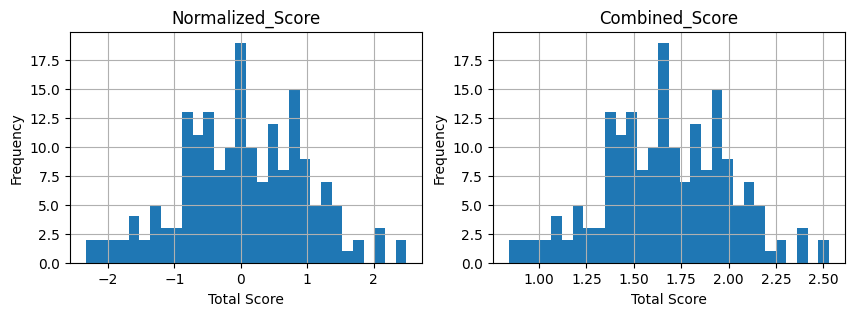

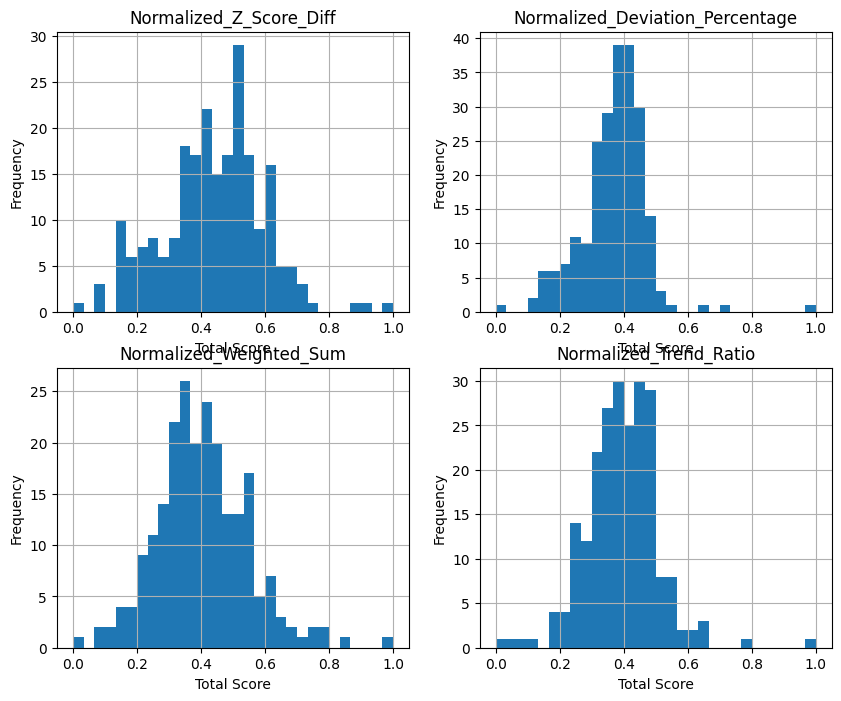

In [22]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import yeojohnson

# Define past seasons and season_weights
past_seasons = ['2022-23', '2021-22', '2020-21', '2019-20', '2018-19']  # Replace with actual season IDs
season_weights = [1.0, 0.5, 0.2, 0.1, 0.1]

# Assuming 'Player_ID' is the column in the DataFrame that contains the player IDs
player_ids = top_players_df['Player_ID'].unique()

# Define a threshold for significant deviation (example: 0.5 standard deviations)
deviation_threshold = 0.7

# Iterate over players to identify buy low/sell high candidates
buy_low_candidates = []
sell_high_candidates = []

# DataFrame to store all players with their stats
candidates_df = pd.DataFrame(columns=['Player_ID', 'Player_Name', 'Current_Season_Avg', 'Current_Season_Std', 'Past_Season_Weighted_Avg', 'Past_Season_Weighted_Std', 'Current_Season_Z_Score', 'Category'])

# First, calculate the mean and standard deviation of past season averages for all players
past_season_averages = []
for player_id in player_ids:
    player_data = summary_df[summary_df['Player_ID'] == player_id]
    player_past_seasons = player_data[player_data['SEASON_ID'].isin(past_seasons)]
    player_past_avg = player_past_seasons['average_total'].mean() if not player_past_seasons.empty else np.nan
    past_season_averages.append(player_past_avg)

mean_past_avg = np.nanmean(past_season_averages)
std_past_avg = np.nanstd(past_season_averages)

# DataFrame to store all players with their stats
candidates_df = pd.DataFrame()
normalized_weighted_sums = []

# Lists to store individual components
components = {'Z_Score_Diff': [], 'Deviation_Percentage': [], 'Current_Method_Score': []}

for player_id in player_ids:
    player_data = summary_df[summary_df['Player_ID'] == player_id]
    current_season_games_played = all_games_df[(all_games_df['Player_ID'] == player_id) & (all_games_df['SEASON_ID'] == CURRENT_SEASON)].shape[0]

    weighted_avg = 0
    total_weight = 0
    weighted_variance = 0

    # Initialize current season variables
    current_season_avg = np.nan
    current_season_std_dev = np.nan
    current_season_z_score = np.nan

    for season, weight in zip(past_seasons, season_weights):
        season_data = player_data[player_data['SEASON_ID'] == season]
        if not season_data.empty:
            season_avg = season_data['average_total'].iloc[0]
            season_std = season_data['std_dev_total'].iloc[0]
            season_variance = season_std ** 2

            weighted_avg += season_avg * weight
            weighted_variance += season_variance * weight
            total_weight += weight

    if total_weight > 0:
        weighted_avg /= total_weight
        weighted_std = np.sqrt(weighted_variance / total_weight)
        past_season_z_score = ((weighted_avg - mean_past_avg) / std_past_avg).round(2)

        # Retrieve current season data
        current_season_data = player_data[player_data['SEASON_ID'] == CURRENT_SEASON]
        if not current_season_data.empty:
            current_season_avg = current_season_data['average_total'].iloc[0]
            current_season_std_dev = current_season_data['std_dev_total'].iloc[0]
            current_season_z_score = current_season_data['z_score'].iloc[0]

            # Calculate components
            z_score_diff = current_season_z_score - past_season_z_score
            deviation_percentage = ((current_season_avg - weighted_avg) / weighted_avg) * 100
            current_method_score = current_season_avg - (weighted_avg - deviation_threshold * weighted_std)

            components['Z_Score_Diff'].append(z_score_diff)
            components['Deviation_Percentage'].append(deviation_percentage)
            components['Current_Method_Score'].append(current_method_score)

            # Prepare row for DataFrame
            new_row = {
                'Player_ID': player_id,
                'Player_Name': player_data['PLAYER_NAME'].iloc[0],
                'Current_Season_Avg': current_season_avg,
                'Current_Season_Std': current_season_std_dev,
                'Current_Season_Games_Played': current_season_games_played,
                'Past_Season_Weighted_Avg': weighted_avg.round(1),
                'Past_Season_Weighted_Std': weighted_std.round(1),
                'Past_Season_Z_Score': past_season_z_score,
                'Current_Season_Z_Score': current_season_z_score,
            }
            candidates_df = pd.concat([candidates_df, pd.DataFrame([new_row])], ignore_index=True)

# Calculate the median of the Trend_Ratio for players with sufficient games
median_trend_ratio = trend_ratio_df['Trend_Ratio'].median()

# Merge with candidates_df
candidates_df = candidates_df.merge(trend_ratio_df, on='Player_ID', how='left') #current season trend ratio

# Fill missing trend ratios with the median value
candidates_df['Trend_Ratio'].fillna(median_trend_ratio, inplace=True)

candidates_df['Pct_Diff_from_Previous_Seasons'] = components['Deviation_Percentage']

# Convert components dictionary to DataFrame
components_df = pd.DataFrame(components)

# Apply the Yeo-Johnson transformation to the Deviation_Percentage
normalized_deviation_percentage, lmbda = yeojohnson(components_df['Deviation_Percentage'])
components_df['Deviation_Percentage'] = normalized_deviation_percentage.round(2)

# Apply Min-Max Normalization
scaler = MinMaxScaler()
components_df[['Normalized_Z_Score_Diff', 'Normalized_Deviation_Percentage', 'Normalized_Current_Method_Score']] = scaler.fit_transform(components_df[['Z_Score_Diff', 'Deviation_Percentage', 'Current_Method_Score']])

# Reshape the 'Trend_Ratio' column into a 2D array
trend_ratio_reshaped = candidates_df['Trend_Ratio'].values.reshape(-1, 1)
# Apply MinMaxScaler to the reshaped data
normalized_trend_ratio = scaler.fit_transform(trend_ratio_reshaped)
# Add the normalized trend ratio back to your DataFrame
components_df['Normalized_Trend_Ratio'] = normalized_trend_ratio.flatten()

# Define weights for each component
final_weights = {
    'Normalized_Z_Score_Diff': 0.9,  # Weight for Z-Score Difference
    'Normalized_Deviation_Percentage': 0.5,  # Weight for Deviation Percentage
    'Normalized_Current_Method_Score': 0.7,  # Weight for Current Method Score
    'Normalized_Trend_Ratio': 2  # Higher weight for Trend Ratio
}

# Calculate the weighted sum of the components
weighted_components = (components_df['Normalized_Z_Score_Diff'] * final_weights['Normalized_Z_Score_Diff'] +
                       components_df['Normalized_Deviation_Percentage'] * final_weights['Normalized_Deviation_Percentage'] +
                       components_df['Normalized_Current_Method_Score'] * final_weights['Normalized_Current_Method_Score'] +
                       components_df['Normalized_Trend_Ratio'] * final_weights['Normalized_Trend_Ratio'])

prev_season_weighted_components = (components_df['Normalized_Z_Score_Diff'] * final_weights['Normalized_Z_Score_Diff'] +
                                   components_df['Normalized_Deviation_Percentage'] * final_weights['Normalized_Deviation_Percentage'] +
                                   components_df['Normalized_Current_Method_Score'] * final_weights['Normalized_Current_Method_Score'])

# Assign the weighted sum to Combined_Score
candidates_df['Combined_Score'] = weighted_components.round(2)
candidates_df['Prev_Season_Combined_Score'] = prev_season_weighted_components.round(2)

# Normalize the weighted sum (Z-score normalization)
mean_weighted = candidates_df['Combined_Score'].mean()
std_weighted = candidates_df['Combined_Score'].std()
candidates_df['Normalized_Score'] = ((candidates_df['Combined_Score'] - mean_weighted) / std_weighted).round(2)

# Assign categories based on normalized score
def assign_category(normalized_score):
    if normalized_score > 1.5:
        return 'Sell High'
    elif normalized_score < -1.5:
        return 'Buy Low'
    else:
        return 'Neutral'

candidates_df['Category'] = candidates_df['Normalized_Score'].apply(assign_category)

candidates_df['Pct_Diff_from_Current_Season'] = ((candidates_df['Trend_Ratio'] - 1) * 100).apply(lambda x: f"{x:.0f}%")
candidates_df['Pct_Diff_from_Previous_Seasons'] = candidates_df['Pct_Diff_from_Previous_Seasons'].apply(lambda x: f"{x:.0f}%")

# filter players with games less than 4 
candidates_df = candidates_df[(candidates_df['Current_Season_Games_Played'] > 4)]# & (candidates_df['Current_Season_Avg'] >= 230)]
candidates_df.sort_values('Current_Season_Avg', ascending=False, inplace=True)
candidates_df = candidates_df.head(185)
candidates_df.sort_values('Normalized_Score', ascending=False, inplace=True)

# Filter to find buy low and sell high candidates
buy_low_candidates_df = candidates_df[candidates_df['Category'] == 'Buy Low']
sell_high_candidates_df = candidates_df[candidates_df['Category'] == 'Sell High']

# Output the DataFrames
print("All Players Data:")
candidates_df.to_csv('candidates.csv', index=False)
print("\nBuy Low Candidates:")
print(buy_low_candidates_df[["Player_Name", "Normalized_Score"]])
print("\nSell High Candidates:")
print(sell_high_candidates_df[["Player_Name", "Normalized_Score"]])
# candidates_df_posting = candidates_df[['Player_Name', 'Current_Season_Avg', 'Pct_Diff_from_Previous_Seasons', 'Pct_Diff_from_Current_Season', 'Normalized_Score']]
# candidates_df_posting.to_csv('candidates_posting.csv', index=False)

import matplotlib.pyplot as plt

# Histograms for Total Scores for Each Season
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
candidates_df['Normalized_Score'].hist(bins=30)
plt.title('Normalized_Score')
plt.xlabel('Total Score')
plt.ylabel('Frequency')

# Histograms for Total Scores for Each Season
plt.subplot(1, 2, 2)
candidates_df['Combined_Score'].hist(bins=30)
plt.title('Combined_Score')
plt.xlabel('Total Score')
plt.ylabel('Frequency')
plt.show()

# Histograms for Total Scores for Each Season
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
components_df['Normalized_Z_Score_Diff'].hist(bins=30)
plt.title('Normalized_Z_Score_Diff')
plt.xlabel('Total Score')
plt.ylabel('Frequency')

# Histograms for Total Scores for Each Season
plt.subplot(2, 2, 2)
components_df['Normalized_Deviation_Percentage'].hist(bins=30)
plt.title('Normalized_Deviation_Percentage')
plt.xlabel('Total Score')
plt.ylabel('Frequency')

# Histograms for Total Scores for Each Season
plt.subplot(2, 2, 3)
components_df['Normalized_Current_Method_Score'].hist(bins=30)
plt.title('Normalized_Weighted_Sum')
plt.xlabel('Total Score')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
components_df['Normalized_Trend_Ratio'].hist(bins=30)
plt.title('Normalized_Trend_Ratio')
plt.xlabel('Total Score')
plt.ylabel('Frequency')
plt.show()


In [42]:
from requests_oauthlib import OAuth1Session

# Define your consumer key (client ID) and consumer secret (client secret)
consumer_key = 'dj0yJmk9UUttc0ZUWHJubndvJmQ9WVdrOVl6VXhkM281V0ZRbWNHbzlNQT09JnM9Y29uc3VtZXJzZWNyZXQmc3Y9MCZ4PTQ1'
consumer_secret = 'd7b46a1c82900c74764678a2f9618ea913bb25b3'

# Create an OAuth session
yahoo = OAuth1Session(consumer_key, client_secret=consumer_secret)

# Access the Fantasy Sports API endpoint for player projections
response = yahoo.get('https://fantasysports.yahooapis.com/fantasy/v2/player/projections')

# Check response status and parse data
if response.status_code == 200:
    projections = response.json()  # Or response.xml() depending on the format
    # Extract the required data from the response
    # ...
else:
    print("Error accessing Yahoo Fantasy Sports API")

https://api.login.yahoo.com/oauth2/request_auth?client_id=[dj0yJmk9UUttc0ZUWHJubndvJmQ9WVdrOVl6VXhkM281V0ZRbWNHbzlNQT09JnM9Y29uc3VtZXJzZWNyZXQmc3Y9MCZ4PTQ1]&redirect_uri=[https://redirectmeto.com/http://localhost:4000/oauth/authorize]&response_type=code&language=en-us

# Client ID (Consumer Key)
# dj0yJmk9UUttc0ZUWHJubndvJmQ9WVdrOVl6VXhkM281V0ZRbWNHbzlNQT09JnM9Y29uc3VtZXJzZWNyZXQmc3Y9MCZ4PTQ1
# Client Secret (Consumer Secret)
# d7b46a1c82900c74764678a2f9618ea913bb25b3

Error accessing Yahoo Fantasy Sports API


In [23]:
import itertools
from datetime import datetime, timedelta

class Team:
    def __init__(self, team_name, player_names, all_games_df):
        self.team_name = team_name
        self.all_games_df = all_games_df
        self.roster = player_names
        self.injured_list = []
        self.tot_roster = self.roster + self.injured_list
        self.max_roster_size = 13
        self.max_injured_size = 2
        self.no_trade_list = []

    def _get_recent_avg(self, player_id, days):
        if days == 'season':
            recent_games = self.all_games_df[(self.all_games_df['Player_ID'] == player_id) & 
                                             (self.all_games_df['SEASON_ID'] == CURRENT_SEASON)]
        else:
            recent_games = self.all_games_df[(self.all_games_df['Player_ID'] == player_id) & 
                                             (self.all_games_df['GAME_DATE'] >= datetime.today() - timedelta(days=days))]
        return recent_games['total_score'].mean().round(2) if not recent_games.empty else 0

    def _get_player_data(self, player_name):
        return self.all_games_df[(self.all_games_df['PLAYER_NAME'] == player_name) & (self.all_games_df['SEASON_ID'] == CURRENT_SEASON)]
    
    def update_no_trade_list(self, player_names):
        """Update the list of players that should not be considered in trade recommendations."""
        self.no_trade_list = player_names

    def get_player_avg_score(self, player_name, days=None):
        player_data = self._get_player_data(player_name)
        if player_data.empty:
            print(f"No data found for player {player_name}")
            return None
        # Implement time frame filtering logic here if needed
        return player_data['total_score'].mean().round(2)

    def add_player(self, player_name):
        if len(self.roster) < self.max_roster_size:
            self.roster.append(player_name)
        else:
            print(f"Roster is full. Remove a player before adding a new one.")

    def remove_player(self, player_name):
        if player_name in self.roster:
            self.roster.remove(player_name)
        else:
            print(f"Player {player_name} not found in the roster.")

    def add_injured_player(self, player_name):
        if len(self.injured_list) < self.max_injured_size:
            self.injured_list.append(player_name)
            self.tot_roster = self.roster + self.injured_list
        else:
            print(f"Injured list is full. Remove a player before adding a new one.")

    def remove_injured_player(self, player_name):
        if player_name in self.injured_list:
            self.injured_list.remove(player_name)
            self.tot_roster.remove(player_name)
        else:
            print(f"Player {player_name} not found in the injured list.")

    def get_team_avg_score(self, days=None):
        scores = [self.get_player_avg_score(player, days) for player in self.roster]
        return (sum(filter(None, scores)) / len(scores)).round(2) if scores else 0
    
    def get_team_avg_score_inc_injury(self, days=None):
        scores = [self.get_player_avg_score(player, days) for player in self.tot_roster]
        return (sum(filter(None, scores)) / len(scores)).round(2) if scores else 0
    
    def view_roster(self):
        print(f"Roster for {self.team_name}:")
        for player in self.roster:
            print(player)
        print()  # Print a newline for better readability

    def view_injury_list(self):
        print(f"Injury list for {self.team_name}:")
        for player in self.injured_list:
            print(player)
        print()  # Print a newline for better readability

    def get_trade_candidates(self, candidates_df):
        # Filter the candidates DataFrame for players in this team's roster
        team_candidates = candidates_df[candidates_df['Player_Name'].isin(self.tot_roster)]
        return team_candidates

    def find_trade_matches(self, other_team, candidates_df, trade_range, trade_threshold, trade_size=1, min_avg_score=250):
        # my_candidates = self.get_trade_candidates(candidates_df)
        # my_sell_highs = my_candidates[my_candidates['Normalized_Score'] > 0]
        my_sell_highs = self.get_trade_candidates(candidates_df)
        my_sell_highs = my_sell_highs[~my_sell_highs['Player_Name'].isin(self.no_trade_list)]
        
        # Filter out players from the no_trade_list
        other_candidates = other_team.get_trade_candidates(candidates_df)
        other_candidates = other_candidates[~other_candidates['Player_Name'].isin(other_team.no_trade_list)]
        
        possible_trades = []
        for my_combination in itertools.combinations(my_sell_highs.iterrows(), trade_size):
            for their_combination in itertools.combinations(other_candidates.iterrows(), trade_size-1): #change trade_size-1 to trade_size if regarding 3v3 or 2v2 trades
                buy_low_count = sum(player[1]['Normalized_Score'] < 0 for player in their_combination)
                low_avg_score_count = sum(player[1]['Current_Season_Avg'] < min_avg_score for player in their_combination)
                # print(f'{other_team}, buy_low_count {buy_low_count}, low_avg_score_count {low_avg_score_count}') # if low avg score count is 0 then skip to next team needed

                avg_scores = {}
                favorable_criteria_count = 0  # Count of favorable criteria
                for days in [7, 14, 30, 'season']:
                    my_avg = round(sum(self._get_recent_avg(player[1]['Player_ID'], days) for player in my_combination) / trade_size, 2)
                    their_avg = round((sum(other_team._get_recent_avg(player[1]['Player_ID'], days) for player in their_combination) + min_avg_score) / (trade_size), 2) #change trade_size-1 to trade_size if regarding 3v3 or 2v2 trades
                    avg_scores[days] = (my_avg, their_avg)

                    # Check if the criteria is met for each time frame
                    if (my_avg/their_avg <= (1 + (trade_range+trade_threshold)/100) and my_avg/their_avg >= (1 - (trade_range-trade_threshold)/100)) :# or (my_avg - their_avg) <= trade_threshold:
                        favorable_criteria_count += 1
                # print(avg_scores)

                if (favorable_criteria_count >= 3 and
                    ((trade_size == 2 and buy_low_count >= 1) or (trade_size > 2 and buy_low_count >= 2)) and
                    low_avg_score_count >= 0): #change low_avg_score_count to 1 if regarding 2v2 or 3v3 trades
                    my_players = [player[1]['Player_Name'] for player in my_combination]
                    their_players = [player[1]['Player_Name'] for player in their_combination]
                    possible_trades.append((my_players, their_players, avg_scores))

        return possible_trades

# Helper function to find trades between two teams
def find_fair_trades(my_team, other_team, candidates_df, trade_range, trade_threshold, trade_size=1, min_avg_score=250):
    return my_team.find_trade_matches(other_team, candidates_df, trade_range, trade_threshold, trade_size, min_avg_score)



In [24]:
# Example usage
team_name1 = '원준'
team_name2 = '루이'
team_name3 = '장혁'
team_name4 = 'yhp'
team_name5 = '로나'
team_name6 = '원기'
team_name7 = '젶'
team_name8 = '종건'
team_name9 = '데릭'
team_name10 = '귤파'

player_names1 = ["De'Anthony Melton", 'Jalen Green', 'Luka Doncic', 'Mikal Bridges', 'LeBron James', 'Jabari Smith Jr.', 'Zach Collins', 'Mark Williams', 'Jarrett Allen', 'Kristaps Porzingis', 'Cade Cunningham', 'Grayson Allen', 'Cam Reddish']
player_names2 = ["De'Aaron Fox", 'Tyrese Maxey', 'Jaylen Brown', 'Michael Porter Jr.', 'Paolo Banchero', 'Giannis Antetokounmpo', 'Brook Lopez', 'Jonas Valanciunas', "D'Angelo Russell", 'Goga Bitadze', 'Klay Thompson', 'Eric Gordon', 'Bilal Coulibaly']
player_names3 = ['Dennis Schroder', 'James Harden', 'Duncan Robinson', 'Kevin Durant', 'Pascal Siakam', 'Zion Williamson', 'Domantas Sabonis', 'Clint Capela', 'Jerami Grant', 'Jusuf Nurkic', 'Caris LeVert', 'Jalen Suggs', 'Julius Randle']
player_names4 = ['Trae Young', 'Kyrie Irving', 'Zach LaVine', 'Jalen Johnson', 'Kyle Kuzma', 'DeMar DeRozan', 'Bam Adebayo', 'Evan Mobley', 'Darius Garland', 'Khris Middleton', 'Ausar Thompson', 'Russell Westbrook', 'Cameron Johnson']
player_names5 = ['Fred VanVleet', 'LaMelo Ball', 'Shai Gilgeous-Alexander', 'Franz Wagner',  'Chet Holmgren', 'Miles Bridges', 'Jaren Jackson Jr.', 'Kevon Looney', 'Josh Giddey',  'Derrick White', 'Shaedon Sharpe', 'Isaiah Stewart', 'Buddy Hield']
player_names6 = ['Jordan Clarkson', 'Brandon Ingram', 'Devin Booker', 'Gordon Hayward', 'Jeremy Sochan', 'Bobby Portis', 'Jakob Poeltl', 'Ivica Zubac', 'Jayson Tatum', 'Aaron Gordon', 'Jalen Brunson', 'Deandre Ayton', 'Lauri Markkanen']
player_names7 = ['Dejounte Murray', 'Malcolm Brogdon', 'Bogdan Bogdanovic', 'John Collins', 'Nikola Jokic', 'Joel Embiid', 'Tyus Jones', 'Nic Claxton', 'Spencer Dinwiddie', 'OG Anunoby', 'Cole Anthony', 'Reggie Jackson']
player_names8 = ['Tyrese Haliburton',  'Jordan Poole', 'Norman Powell', 'Tobias Harris', 'Scottie Barnes', 'Herbert Jones', 'Karl-Anthony Towns', 'Moritz Wagner', 'Alperen Sengun', 'Victor Wembanyama', 'Andrew Wiggins', 'Ja Morant', 'Draymond Green']
player_names9 = ['Stephen Curry', 'Max Strus', 'Chris Paul', 'Keldon Johnson', 'Anthony Edwards', 'Nikola Vucevic', 'Onyeka Okongwu', 'Jimmy Butler', 'Paul George', 'RJ Barrett', 'Rudy Gobert', 'Santi Aldama']
player_names10 = ['Damian Lillard', 'Keyonte George', 'Jrue Holiday', 'Desmond Bane', 'Anthony Davis', 'Austin Reaves', 'Myles Turner', 'Daniel Gafford', 'Kawhi Leonard', 'Lonnie Walker IV', 'Mitchell Robinson', 'Deni Avdija', 'Jalen Williams']


In [25]:
team1 = Team(team_name1, player_names1, all_games_df)
team1.add_injured_player('Jamal Murray')
team1.add_injured_player('Kelly Oubre Jr.')
team1.update_no_trade_list(['Kristaps Porzingis'])
print(f'{team_name1} average score: {team1.get_team_avg_score()}, including injury: {team1.get_team_avg_score_inc_injury()}')
# team1.view_roster()
# team1.view_injury_list()

team2 = Team(team_name2, player_names2, all_games_df)
team2.add_injured_player('Donovan Mitchell')
team2.add_injured_player('Devin Vassell')
print(f'{team_name2} average score: {team2.get_team_avg_score()}, including injury: {team2.get_team_avg_score_inc_injury()}')

team3 = Team(team_name3, player_names3, all_games_df)
team3.add_injured_player('Tyler Herro')
team3.add_injured_player('Ben Simmons')
team3.update_no_trade_list(['Zion Williamson', 'Ben Simmons', 'Kevin Durant'])
print(f'{team_name3} average score: {team3.get_team_avg_score()}, including injury: {team3.get_team_avg_score_inc_injury()}')

team4 = Team(team_name4, player_names4, all_games_df)
team4.add_injured_player('Walker Kessler')
team4.add_injured_player('Wendell Carter Jr.')
team4.update_no_trade_list(['Khris Middleton', 'Jalen Johnson', 'Cameron Johnson', 'Zach LaVine'])
print(f'{team_name4} average score: {team4.get_team_avg_score()}, including injury: {team4.get_team_avg_score_inc_injury()}')

team5 = Team(team_name5, player_names5, all_games_df)
team5.add_injured_player('Marcus Smart')
team5.add_injured_player('Jalen Duren')
print(f'{team_name5} average score: {team5.get_team_avg_score()}, including injury: {team5.get_team_avg_score_inc_injury()}')

team6 = Team(team_name6, player_names6, all_games_df)
team6.add_injured_player('Anfernee Simons')
print(f'{team_name6} average score: {team6.get_team_avg_score()}, including injury: {team6.get_team_avg_score_inc_injury()}')

team7 = Team(team_name7, player_names7, all_games_df)
team7.add_injured_player('CJ McCollum')
team7.update_no_trade_list(['Tre Jones'])
print(f'{team_name7} average score: {team7.get_team_avg_score()}, including injury: {team7.get_team_avg_score_inc_injury()}')

team8 = Team(team_name8, player_names8, all_games_df)
team8.add_injured_player('Markelle Fultz')
print(f'{team_name8} average score: {team8.get_team_avg_score()}, including injury: {team8.get_team_avg_score_inc_injury()}')

team9 = Team(team_name9, player_names9, all_games_df)
team9.add_injured_player('Cam Thomas')
team9.add_injured_player('Bradley Beal')
team9.update_no_trade_list(['Paul George'])
print(f'{team_name9} average score: {team9.get_team_avg_score()}, including injury: {team9.get_team_avg_score_inc_injury()}')

team10 = Team(team_name10, player_names10, all_games_df)
team10.add_injured_player('Cam Thomas')
team10.add_injured_player('Bradley Beal')
team10.update_no_trade_list(['Kawhi Leonard', 'Anthony Davis'])
print(f'{team_name10} average score: {team10.get_team_avg_score()}, including injury: {team10.get_team_avg_score_inc_injury()}')

원준 average score: 329.5, including injury: 324.87
루이 average score: 346.35, including injury: 350.24
장혁 average score: 347.58, including injury: 345.57
yhp average score: 348.05, including injury: 332.98
로나 average score: 333.6, including injury: 328.61
원기 average score: 342.86, including injury: 342.23
젶 average score: 353.02, including injury: 357.69
No data found for player Ja Morant
No data found for player Ja Morant
종건 average score: 308.06, including injury: 305.32
데릭 average score: 321.51, including injury: 320.84
귤파 average score: 322.98, including injury: 322.12


In [26]:
teams = [team10, team9, team8, team7, team6, team5, team4, team3, team2, team1]
trade_range = 3 #means 3% difference(-3% to 3%)
trade_threshold = 1 #means 1% from trade range (-4% to 2%)
my_team = team4
min_avg_score = 250

print(f'finding trade range of {-1*trade_range - trade_threshold}% to {trade_range - trade_threshold}%')
for other_team in teams:
    if other_team != my_team:
        for trade_size in range(2, 4):
            fair_trades = find_fair_trades(my_team, other_team, candidates_df, trade_range=trade_range, trade_threshold=trade_threshold, trade_size=trade_size, min_avg_score=min_avg_score)
            for trade in fair_trades:
                my_players, their_players, avg_scores = trade
                print(f"Trade suggestion:\n{my_players} ({my_team.team_name}) for {their_players} ({other_team.team_name})")
                for days, scores in avg_scores.items():
                    my_avg, their_avg = scores
                    diff = round(my_avg - their_avg, 2) * -1
                    pct_diff = round((1 - my_avg / their_avg) * 100, 2)
                    if days == 'season':
                        print(f"Season Avg Score: {my_avg} vs {their_avg}, Diff: {diff}, % Diff: {pct_diff}%")
                    else:
                        print(f"{days}-day Avg Score: {my_avg} vs {their_avg}, Diff: {diff}, % Diff: {pct_diff}%")
                print("\n")  # Print a newline for better readability


finding trade range of -4% to 2%
Trade suggestion:
['Kyle Kuzma', 'Walker Kessler', 'Russell Westbrook'] (yhp) for ['Mitchell Robinson', 'Damian Lillard'] (귤파)
7-day Avg Score: 316.58 vs 321.5, Diff: 4.92, % Diff: 1.53%
14-day Avg Score: 337.92 vs 326.12, Diff: -11.8, % Diff: -3.62%
30-day Avg Score: 331.72 vs 324.24, Diff: -7.48, % Diff: -2.31%
Season Avg Score: 316.68 vs 311.47, Diff: -5.21, % Diff: -1.67%


Trade suggestion:
['Kyle Kuzma', 'Walker Kessler', 'Russell Westbrook'] (yhp) for ['Damian Lillard', 'Jrue Holiday'] (귤파)
7-day Avg Score: 316.58 vs 310.67, Diff: -5.91, % Diff: -1.9%
14-day Avg Score: 337.92 vs 320.15, Diff: -17.77, % Diff: -5.55%
30-day Avg Score: 331.72 vs 318.97, Diff: -12.75, % Diff: -4.0%
Season Avg Score: 316.68 vs 316.21, Diff: -0.47, % Diff: -0.15%


Trade suggestion:
['Kyle Kuzma', 'Darius Garland', 'Russell Westbrook'] (yhp) for ['Damian Lillard', 'Jrue Holiday'] (귤파)
7-day Avg Score: 305.31 vs 310.67, Diff: 5.36, % Diff: 1.73%
14-day Avg Score: 321.03